# Proyecto 2
## Hacking the Human Vasculature
- Fabiola Contreras
- Diego Duarte
- Christian Echeverría
- María José Villafuerte

### Configuración e Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

### Carga de datos

In [13]:
# Cargar metadatos de tiles
tile_meta = pd.read_csv('./data/tile_meta.csv')

# Cargar metadatos de WSI (Whole Slide Images)
wsi_meta = pd.read_csv('./data/wsi_meta.csv')

# Cargar datos de polígonos (anotaciones)
polygons_data = []
with open('./data/polygons.jsonl', 'r') as f:
    for line in f:
        if line.strip():
            polygons_data.append(json.loads(line))

print("Datos cargados exitosamente")
print(f"Archivos cargados: {len([tile_meta, wsi_meta, polygons_data])} datasets")

Datos cargados exitosamente
Archivos cargados: 3 datasets


### Descripción de variables

In [14]:
print("\n" + "="*60)
print("📊 RESUMEN GENERAL DEL DATASET")
print("="*60)

def analyze_dataset_structure(df, name):
    print(f"\n{name}")
    print("-" * 40)
    print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
    print(f"Memoria utilizada: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print(f"\nInformación de columnas:")
    info_df = pd.DataFrame({
        'Columna': df.columns,
        'Tipo de dato': df.dtypes.astype(str),
        'Valores no nulos': df.count(),
        'Valores nulos': df.isnull().sum(),
        '% Nulos': (df.isnull().sum() / len(df) * 100).round(2)
    })
    print(info_df.to_string(index=False))
    
    return info_df

# Análisis de estructura
tile_info = analyze_dataset_structure(tile_meta, "TILE METADATA")
wsi_info = analyze_dataset_structure(wsi_meta, "WSI METADATA")

# Análisis de datos de polígonos
print(f"\nPOLYGON ANNOTATIONS")
print("-" * 40)
print(f"Total de imágenes anotadas: {len(polygons_data):,}")

# Extraer información de anotaciones
annotation_stats = []
for img_data in polygons_data:
    img_id = img_data.get('id', 'unknown')
    annotations = img_data.get('annotations', [])
    
    for ann in annotations:
        annotation_stats.append({
            'image_id': img_id,
            'type': ann.get('type', 'unknown'),
            'num_coordinates': len(ann.get('coordinates', []))
        })

annotations_df = pd.DataFrame(annotation_stats)
print(f"Total de anotaciones: {len(annotations_df):,}")
print(f"Tipos de anotaciones: {annotations_df['type'].nunique()}")


📊 RESUMEN GENERAL DEL DATASET

TILE METADATA
----------------------------------------
Dimensiones: 7,033 filas × 5 columnas
Memoria utilizada: 0.62 MB

Información de columnas:
   Columna Tipo de dato  Valores no nulos  Valores nulos  % Nulos
        id       object              7033              0      0.0
source_wsi        int64              7033              0      0.0
   dataset        int64              7033              0      0.0
         i        int64              7033              0      0.0
         j        int64              7033              0      0.0

WSI METADATA
----------------------------------------
Dimensiones: 4 filas × 7 columnas
Memoria utilizada: 0.00 MB

Información de columnas:
   Columna Tipo de dato  Valores no nulos  Valores nulos  % Nulos
source_wsi        int64                 4              0      0.0
       age        int64                 4              0      0.0
       sex       object                 4              0      0.0
      race       obj

In [15]:
print("\n" + "="*60)
print("📈 ANÁLISIS DE VARIABLES NUMÉRICAS")
print("="*60)

print(tile_meta.describe())
print()
print(wsi_meta.describe())


📈 ANÁLISIS DE VARIABLES NUMÉRICAS
        source_wsi      dataset             i             j
count  7033.000000  7033.000000   7033.000000   7033.000000
mean      8.205744     2.707806  14296.542585  23227.014930
std       4.004251     0.571724   5946.054578  10644.032931
min       1.000000     1.000000   1536.000000   2560.000000
25%       6.000000     3.000000   9728.000000  15265.000000
50%       9.000000     3.000000  13824.000000  22528.000000
75%      12.000000     3.000000  18944.000000  29656.000000
max      14.000000     3.000000  30208.000000  52753.000000

       source_wsi        age     height      weight       bmi
count    4.000000   4.000000    4.00000    4.000000   4.00000
mean     2.500000  60.000000  165.87500   89.775000  32.05000
std      1.290994   8.906926    6.68998   35.195679   9.91514
min      1.000000  53.000000  160.00000   59.000000  23.00000
25%      1.750000  55.250000  161.72500   69.500000  25.62500
50%      2.500000  57.000000  164.15000   80.250000 

In [16]:
print("\n" + "="*60)
print("📋 ANÁLISIS DE VARIABLES CATEGÓRICAS")
print("="*60)

def categorical_analysis(df, name):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    if len(categorical_cols) == 0:
        print(f"\nNo se encontraron variables categóricas en {name}")
        return None
    
    print(f"\nAnálisis de frecuencias - {name}")
    print("-" * 50)
    
    for col in categorical_cols:
        if (col == "image_id"):
            continue
        print(f"\nVariable: {col}")
        print("-" * 25)
        
        freq_table = df[col].value_counts(dropna=False)
        freq_df = pd.DataFrame({
            'Categoría': freq_table.index,
            'Frecuencia': freq_table.values,
            'Porcentaje': (freq_table.values / len(df) * 100).round(2),
            'Porcentaje_acum': (freq_table.values / len(df) * 100).cumsum().round(2)
        })
        
        print(freq_df.to_string(index=False))
        print(f"Valores únicos: {df[col].nunique()}")
        print(f"Valores faltantes: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")

# Análisis categórico
categorical_analysis(wsi_meta, "WSI METADATA")
categorical_analysis(annotations_df, "ANNOTATIONS")


📋 ANÁLISIS DE VARIABLES CATEGÓRICAS

Análisis de frecuencias - WSI METADATA
--------------------------------------------------

Variable: sex
-------------------------
Categoría  Frecuencia  Porcentaje  Porcentaje_acum
        F           3        75.0             75.0
        M           1        25.0            100.0
Valores únicos: 2
Valores faltantes: 0 (0.00%)

Variable: race
-------------------------
Categoría  Frecuencia  Porcentaje  Porcentaje_acum
        W           3        75.0             75.0
        B           1        25.0            100.0
Valores únicos: 2
Valores faltantes: 0 (0.00%)

Análisis de frecuencias - ANNOTATIONS
--------------------------------------------------

Variable: type
-------------------------
   Categoría  Frecuencia  Porcentaje  Porcentaje_acum
blood_vessel       16054       91.64            91.64
      unsure         897        5.12            96.76
  glomerulus         567        3.24           100.00
Valores únicos: 3
Valores faltantes: 0 (0

In [17]:
print("\n" + "="*60)
print("🔗 ANÁLISIS DE CRUCES ENTRE VARIABLES")
print("="*60)

# Cruce 1: Dataset vs Source WSI
if 'dataset' in tile_meta.columns and 'source_wsi' in tile_meta.columns:
    print("\n📊 Cruce: Dataset × Source WSI")
    print("-" * 40)
    cross_dataset_wsi = pd.crosstab(tile_meta['dataset'], tile_meta['source_wsi'], margins=True)
    print(cross_dataset_wsi)

# Cruce 2: Unir tile_meta con wsi_meta para análisis demográfico
if 'source_wsi' in tile_meta.columns and 'source_wsi' in wsi_meta.columns:
    merged_data = tile_meta.merge(wsi_meta, on='source_wsi', how='left')
    
    # Cruce 3: Dataset vs características demográficas
    if 'dataset' in merged_data.columns:
        demo_cols = ['sex', 'race'] if all(col in merged_data.columns for col in ['sex', 'race']) else []
        
        for demo_col in demo_cols:
            if demo_col in merged_data.columns:
                print(f"\n📊 Cruce: Dataset × {demo_col.title()}")
                print("-" * 40)
                cross_demo = pd.crosstab(merged_data['dataset'], merged_data[demo_col], margins=True)
                print(cross_demo)
                
                # Porcentajes
                print(f"\n📊 Porcentajes - Dataset × {demo_col.title()}")
                cross_demo_pct = pd.crosstab(merged_data['dataset'], merged_data[demo_col], normalize='index') * 100
                print(cross_demo_pct.round(2))

# Cruce 4: Tipo de anotación vs número de coordenadas
if len(annotations_df) > 0:
    print(f"\n📊 Cruce: Tipo de anotación × Estadísticas de coordenadas")
    print("-" * 55)
    coord_stats = annotations_df.groupby('type')['num_coordinates'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(2)
    print(coord_stats)


🔗 ANÁLISIS DE CRUCES ENTRE VARIABLES

📊 Cruce: Dataset × Source WSI
----------------------------------------
source_wsi    1    2    3    4    6    7    8    9   10   11   12   13   14  \
dataset                                                                       
1           270  152    0    0    0    0    0    0    0    0    0    0    0   
2           237  293  410  271    0    0    0    0    0    0    0    0    0   
3             0    0    0    0  600  600  600  600  600  600  600  600  600   
All         507  445  410  271  600  600  600  600  600  600  600  600  600   

source_wsi   All  
dataset           
1            422  
2           1211  
3           5400  
All         7033  

📊 Cruce: Dataset × Sex
----------------------------------------
sex         F    M   All
dataset                 
1         422    0   422
2         940  271  1211
All      1362  271  1633

📊 Porcentajes - Dataset × Sex
sex           F      M
dataset               
1        100.00   0.00
2         7

### Graficos exploratorios

In [18]:
tile_num_cols = tile_meta.select_dtypes(include=[np.number]).columns
wsi_num_cols = wsi_meta.select_dtypes(include=[np.number]).columns

In [19]:
# Matriz de correlación
if wsi_num_cols is not None and len(wsi_num_cols) > 1:
    print("\n📊 Matriz de correlación - Variables demográficas")
    print("-" * 50)
    correlation_matrix = wsi_meta[wsi_num_cols].corr()
    print(correlation_matrix.round(3))


📊 Matriz de correlación - Variables demográficas
--------------------------------------------------
            source_wsi    age  height  weight    bmi
source_wsi       1.000  0.029   0.098  -0.037 -0.023
age              0.029  1.000  -0.408  -0.053  0.068
height           0.098 -0.408   1.000   0.922  0.873
weight          -0.037 -0.053   0.922   1.000  0.993
bmi             -0.023  0.068   0.873   0.993  1.000


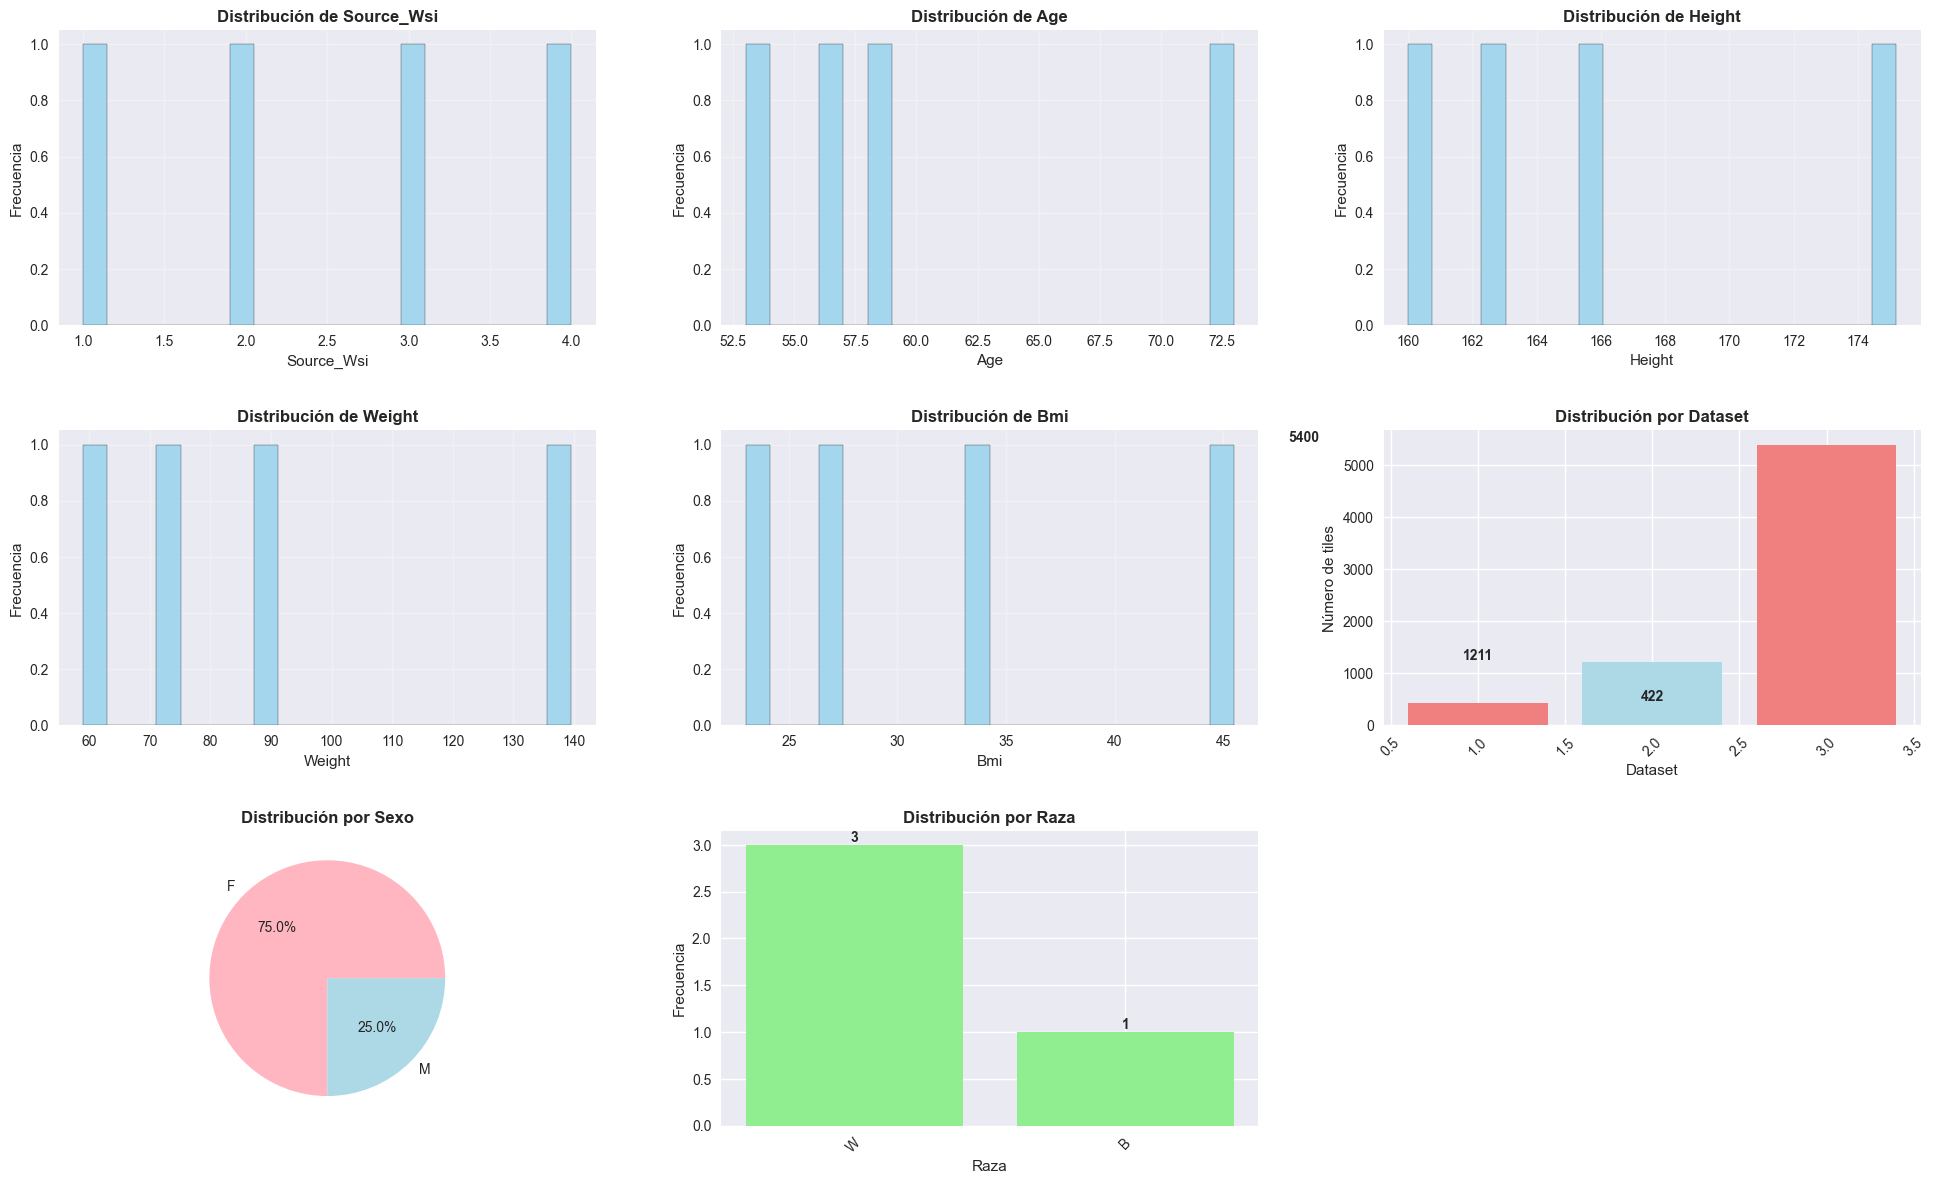

In [ ]:
# Configurar subplots
fig = plt.figure(figsize=(20, 24))

# Histogramas de variables numéricas demográficas
if wsi_num_cols is not None and len(wsi_num_cols) > 0:
    for i, col in enumerate(wsi_num_cols):
        plt.subplot(6, 3, i+1)
        plt.hist(wsi_meta[col].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Distribución de {col.title()}', fontweight='bold')
        plt.xlabel(col.title())
        plt.ylabel('Frecuencia')
        plt.grid(True, alpha=0.3)

# Gráficos de barras para variables categóricas
subplot_idx = len(wsi_num_cols) + 1 if wsi_num_cols is not None else 1

# Dataset distribution
if 'dataset' in tile_meta.columns:
    plt.subplot(6, 3, subplot_idx)
    dataset_counts = tile_meta['dataset'].value_counts()
    plt.bar(dataset_counts.index, dataset_counts.values, color=['lightcoral', 'lightblue'])
    plt.title('Distribución por Dataset', fontweight='bold')
    plt.xlabel('Dataset')
    plt.ylabel('Número de tiles')
    plt.xticks(rotation=45)
    for i, v in enumerate(dataset_counts.values):
        plt.text(i, v + max(dataset_counts.values)*0.01, str(v), ha='center', fontweight='bold')
    subplot_idx += 1

# Sex distribution
if 'sex' in wsi_meta.columns:
    plt.subplot(6, 3, subplot_idx)
    sex_counts = wsi_meta['sex'].value_counts()
    colors = ['lightpink', 'lightblue'] if len(sex_counts) == 2 else plt.cm.Set3(np.linspace(0, 1, len(sex_counts)))
    plt.pie(sex_counts.values, labels=sex_counts.index, autopct='%1.1f%%', colors=colors)
    plt.title('Distribución por Sexo', fontweight='bold')
    subplot_idx += 1

# Race distribution
if 'race' in wsi_meta.columns:
    plt.subplot(6, 3, subplot_idx)
    race_counts = wsi_meta['race'].value_counts()
    plt.bar(range(len(race_counts)), race_counts.values, color='lightgreen')
    plt.title('Distribución por Raza', fontweight='bold')
    plt.xlabel('Raza')
    plt.ylabel('Frecuencia')
    plt.xticks(range(len(race_counts)), race_counts.index, rotation=45)
    for i, v in enumerate(race_counts.values):
        plt.text(i, v + max(race_counts.values)*0.01, str(v), ha='center', fontweight='bold')
    subplot_idx += 1

plt.tight_layout(pad=3.0)
plt.show()

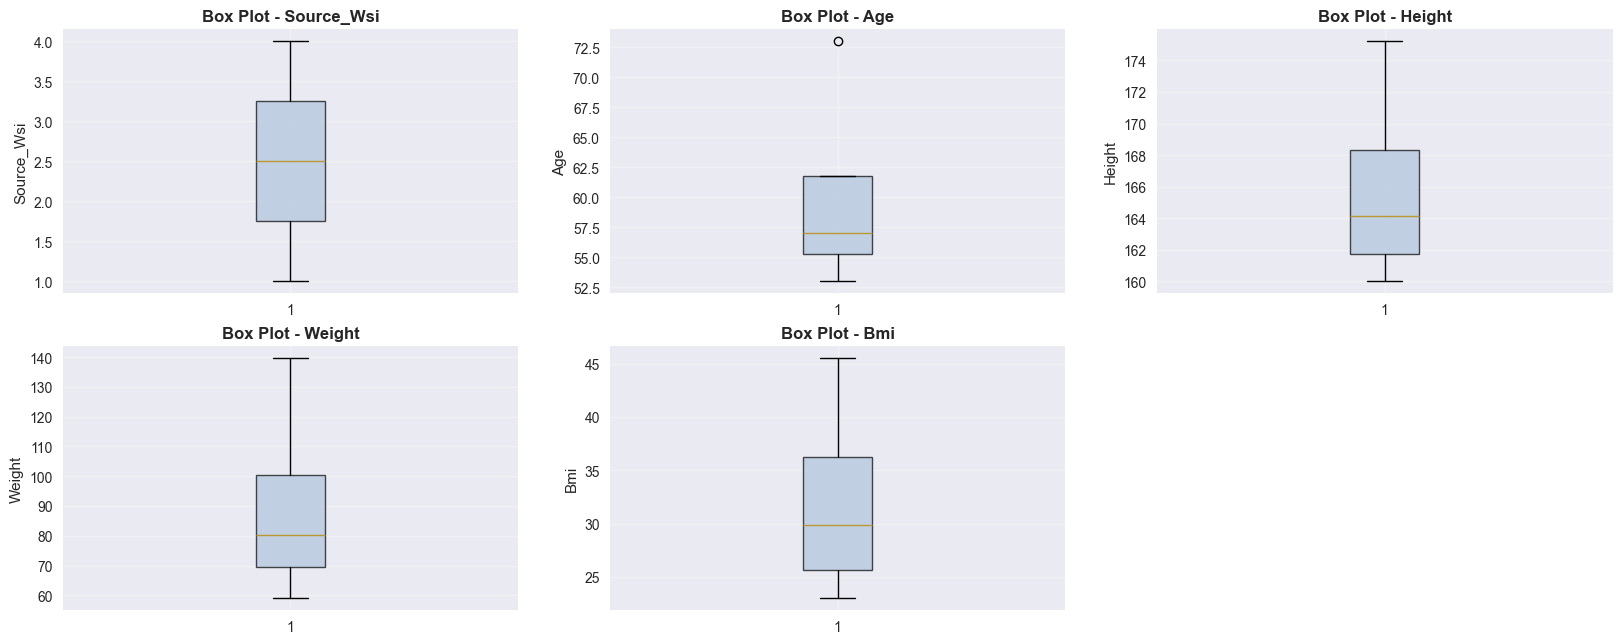

In [32]:
# Configurar subplots
fig = plt.figure(figsize=(20, 24))

# Box plots
if wsi_num_cols is not None and len(wsi_num_cols) > 0:
    for i, col in enumerate(wsi_num_cols):
        plt.subplot(6, 3, i +1)
        plt.boxplot(wsi_meta[col].dropna(), patch_artist=True,
                    boxprops=dict(facecolor='lightsteelblue', alpha=0.7))
        plt.title(f'Box Plot - {col.title()}', fontweight='bold')
        plt.ylabel(col.title())
        plt.grid(True, alpha=0.3)

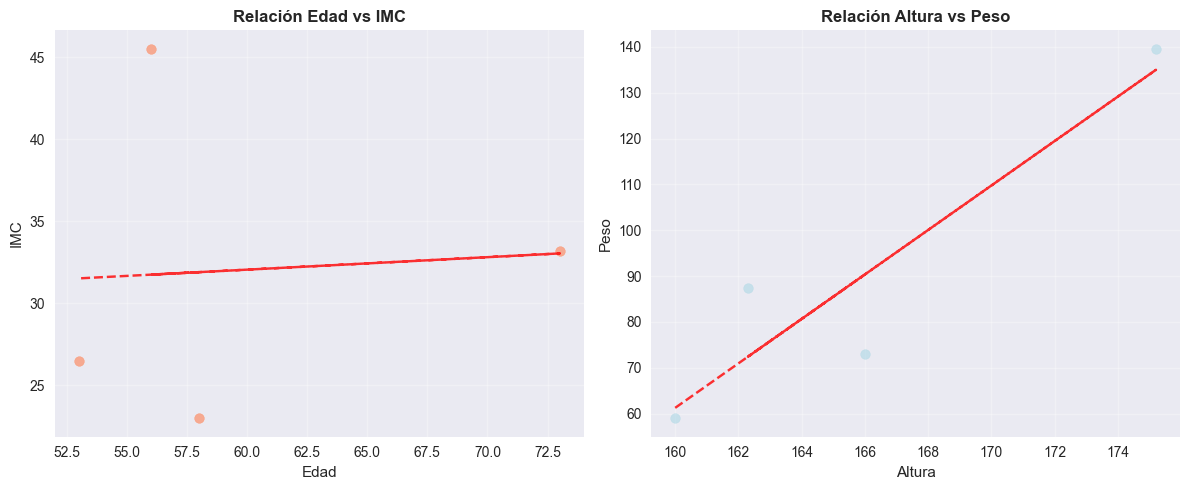

In [21]:
# Gráficos de dispersión
if 'age' in wsi_meta.columns and 'bmi' in wsi_meta.columns:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(wsi_meta['age'], wsi_meta['bmi'], alpha=0.6, color='coral')
    plt.xlabel('Edad')
    plt.ylabel('IMC')
    plt.title('Relación Edad vs IMC', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Agregar línea de tendencia
    if not wsi_meta[['age', 'bmi']].isnull().all().any():
        z = np.polyfit(wsi_meta['age'].dropna(), wsi_meta['bmi'].dropna(), 1)
        p = np.poly1d(z)
        plt.plot(wsi_meta['age'], p(wsi_meta['age']), "r--", alpha=0.8)

if 'height' in wsi_meta.columns and 'weight' in wsi_meta.columns:
    plt.subplot(1, 2, 2)
    plt.scatter(wsi_meta['height'], wsi_meta['weight'], alpha=0.6, color='lightblue')
    plt.xlabel('Altura')
    plt.ylabel('Peso')
    plt.title('Relación Altura vs Peso', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Agregar línea de tendencia
    if not wsi_meta[['height', 'weight']].isnull().all().any():
        z = np.polyfit(wsi_meta['height'].dropna(), wsi_meta['weight'].dropna(), 1)
        p = np.poly1d(z)
        plt.plot(wsi_meta['height'], p(wsi_meta['height']), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()

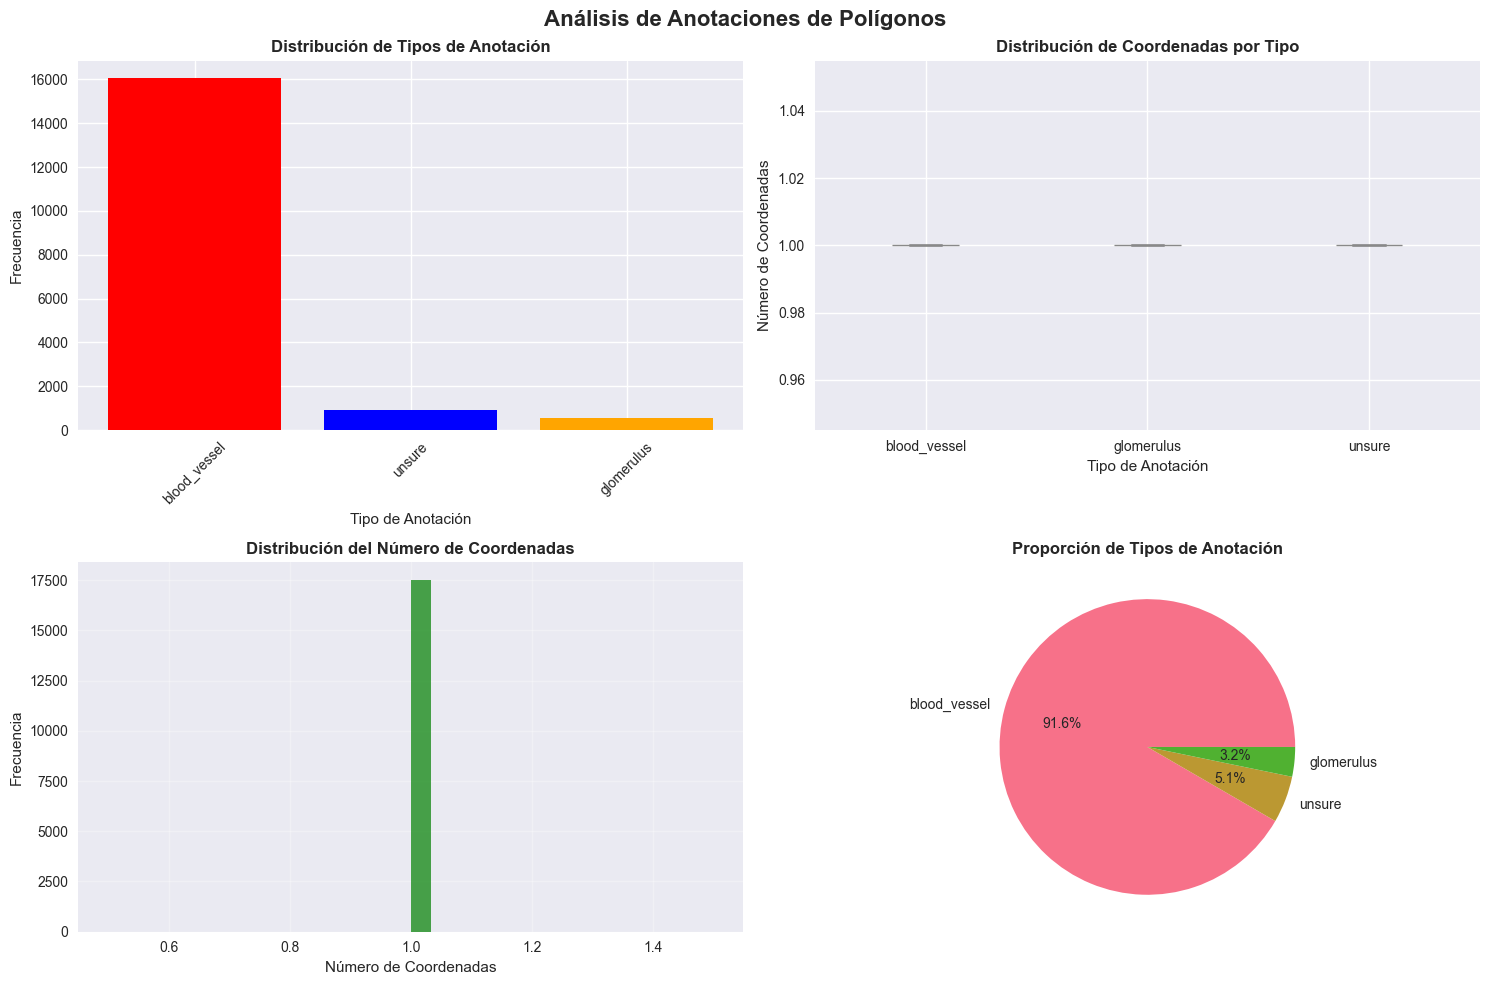

In [22]:
# Análisis de anotaciones
if len(annotations_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribución de tipos de anotación
    type_counts = annotations_df['type'].value_counts()
    axes[0, 0].bar(type_counts.index, type_counts.values, 
                   color=['red', 'blue', 'orange'])
    axes[0, 0].set_title('Distribución de Tipos de Anotación', fontweight='bold')
    axes[0, 0].set_xlabel('Tipo de Anotación')
    axes[0, 0].set_ylabel('Frecuencia')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Box plot de coordenadas por tipo
    annotations_df.boxplot(column='num_coordinates', by='type', ax=axes[0, 1])
    axes[0, 1].set_title('Distribución de Coordenadas por Tipo', fontweight='bold')
    axes[0, 1].set_xlabel('Tipo de Anotación')
    axes[0, 1].set_ylabel('Número de Coordenadas')
    
    # Histograma de coordenadas
    axes[1, 0].hist(annotations_df['num_coordinates'], bins=30, alpha=0.7, color='green')
    axes[1, 0].set_title('Distribución del Número de Coordenadas', fontweight='bold')
    axes[1, 0].set_xlabel('Número de Coordenadas')
    axes[1, 0].set_ylabel('Frecuencia')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Pie chart de tipos de anotación
    axes[1, 1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Proporción de Tipos de Anotación', fontweight='bold')
    
    plt.suptitle('Análisis de Anotaciones de Polígonos', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

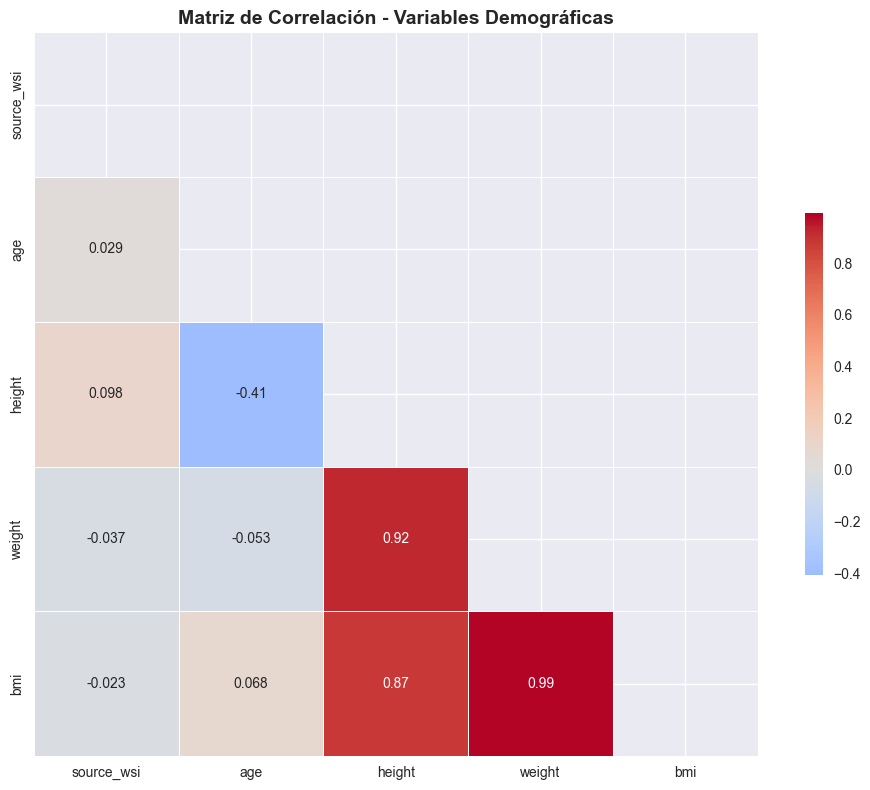

In [23]:
# Mapa de calor
if wsi_num_cols is not None and len(wsi_num_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = wsi_meta[wsi_num_cols].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', 
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
    plt.title('Matriz de Correlación - Variables Demográficas', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

### Resumen

In [25]:
print("\n" + "="*80)
print("📋 RESUMEN DEL ANÁLISIS")
print("="*80)

print(f"""
CARACTERÍSTICAS PRINCIPALES DEL DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DIMENSIONES:
   • Tiles metadata: {tile_meta.shape[0]:,} tiles × {tile_meta.shape[1]} variables
   • WSI metadata: {wsi_meta.shape[0]:,} imágenes completas × {wsi_meta.shape[1]} variables  
   • Anotaciones: {len(annotations_df):,} anotaciones en {len(polygons_data):,} imágenes

TIPOS DE ANOTACIONES:
   • Blood vessels (objetivo principal): {annotations_df[annotations_df['type']=='blood_vessel'].shape[0]:,} anotaciones
   • Glomerulus (exclusión): {annotations_df[annotations_df['type']=='glomerulus'].shape[0]:,} anotaciones  
   • Unsure (inciertos): {annotations_df[annotations_df['type']=='unsure'].shape[0]:,} anotaciones

CARACTERÍSTICAS DEMOGRÁFICAS:
   • Rango de edad: {wsi_meta['age'].min():.0f} - {wsi_meta['age'].max():.0f} años (promedio: {wsi_meta['age'].mean():.1f})
   • Distribución por sexo: {dict(wsi_meta['sex'].value_counts())}
   • Rango IMC: {wsi_meta['bmi'].min():.1f} - {wsi_meta['bmi'].max():.1f} (promedio: {wsi_meta['bmi'].mean():.1f})
""")


📋 RESUMEN DEL ANÁLISIS

CARACTERÍSTICAS PRINCIPALES DEL DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

DIMENSIONES:
   • Tiles metadata: 7,033 tiles × 5 variables
   • WSI metadata: 4 imágenes completas × 7 variables  
   • Anotaciones: 17,518 anotaciones en 1,633 imágenes

TIPOS DE ANOTACIONES:
   • Blood vessels (objetivo principal): 16,054 anotaciones
   • Glomerulus (exclusión): 567 anotaciones  
   • Unsure (inciertos): 897 anotaciones

CARACTERÍSTICAS DEMOGRÁFICAS:
   • Rango de edad: 53 - 73 años (promedio: 60.0)
   • Distribución por sexo: {'F': 3, 'M': 1}
   • Rango IMC: 23.0 - 45.5 (promedio: 32.0)

